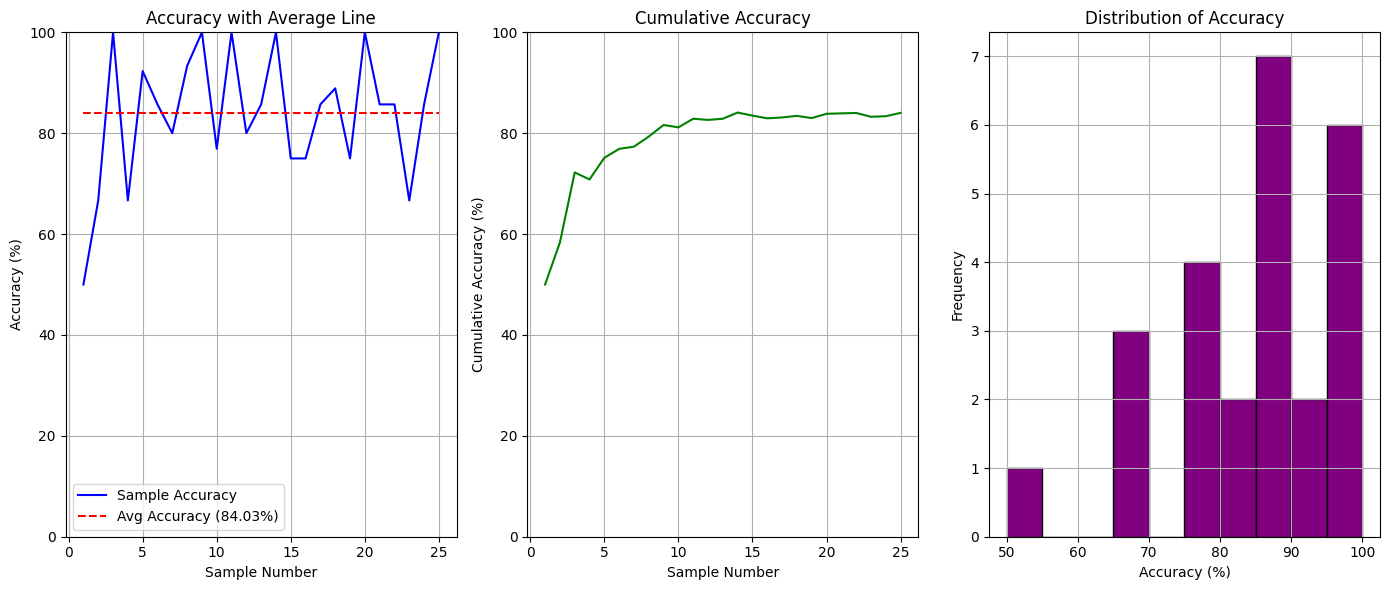

In [19]:
import cv2
import pytesseract
from tkinter import *
from PIL import ImageGrab, Image
import numpy as np
import pyttsx3
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
import pandas as pd

# Path to Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Initialize the text-to-speech engine and other variables
engine = pyttsx3.init()
recognized_texts = []
correct_texts = []
accuracies = []
sample_count = 0
max_samples = 25

# Initialize the main window
window = Tk()
window.title("Handwritten Recognition Accuracy Collection")
window.geometry("800x700")

# Canvas for drawing
canvas = Canvas(window, width=600, height=400, bg="white")
canvas.pack(pady=20)

# Variables to store mouse position for drawing
last_x, last_y = None, None

def activate_paint(e):
    global last_x, last_y
    last_x, last_y = e.x, e.y

def draw(e):
    global last_x, last_y
    x, y = e.x, e.y
    canvas.create_line((last_x, last_y, x, y), fill='black', width=5)
    last_x, last_y = x, y

def erase_canvas():
    canvas.delete("all")

canvas.bind("<Button-1>", activate_paint)
canvas.bind("<B1-Motion>", draw)

def translate_text():
    global recognized_text
    x = window.winfo_rootx() + canvas.winfo_x()
    y = window.winfo_rooty() + canvas.winfo_y()
    x1 = x + canvas.winfo_width()
    y1 = y + canvas.winfo_height()
    img = ImageGrab.grab().crop((x, y, x1, y1)).convert("L")
    img = np.array(img)
    
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    recognized_text = pytesseract.image_to_string(img, config='--psm 6').strip()
    label_text.configure(text="Recognized: " + recognized_text)

def calculate_accuracy(recognized, correct):
    recognized = recognized.strip()
    correct = correct.strip()
    return SequenceMatcher(None, recognized, correct).ratio() * 100

def next_sample():
    global sample_count
    correct_text = entry_correct_text.get()
    if not correct_text:
        label_feedback.configure(text="Please enter the correct text for comparison.", fg="red")
        return

    if sample_count >= max_samples:
        show_results()
        window.destroy()
        return
    
    accuracy = calculate_accuracy(recognized_text, correct_text)
    accuracies.append(accuracy)
    recognized_texts.append(recognized_text)
    correct_texts.append(correct_text)
    
    label_feedback.configure(text=f"Sample {sample_count + 1}: {accuracy:.2f}% accuracy", fg="green")
    sample_count += 1
    label_counter.configure(text=f"Sample {sample_count} of {max_samples}")
    
    entry_correct_text.delete(0, END)
    erase_canvas()

    if sample_count >= max_samples:
        show_results()
        window.destroy()

# Show additional visualizations after all samples are completed
def show_results():
    if len(accuracies) != max_samples:
        return
    
    avg_accuracy = sum(accuracies) / max_samples
    label_feedback.configure(text=f"Overall Average Accuracy: {avg_accuracy:.2f}%", fg="blue")
    
    plt.figure(figsize=(14, 6))

    # Average Accuracy Line Plot
    plt.subplot(1, 3, 1)
    avg_line = [avg_accuracy] * max_samples
    plt.plot(range(1, max_samples + 1), accuracies, label="Sample Accuracy", color='blue')
    plt.plot(range(1, max_samples + 1), avg_line, label=f"Avg Accuracy ({avg_accuracy:.2f}%)", color='red', linestyle='--')
    plt.title("Accuracy with Average Line")
    plt.xlabel("Sample Number")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(True)

    # Cumulative Accuracy Over Samples
    plt.subplot(1, 3, 2)
    cumulative_accuracy = np.cumsum(accuracies) / np.arange(1, max_samples + 1)
    plt.plot(range(1, max_samples + 1), cumulative_accuracy, color='green')
    plt.title("Cumulative Accuracy")
    plt.xlabel("Sample Number")
    plt.ylabel("Cumulative Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(True)

    # Distribution of Accuracy
    plt.subplot(1, 3, 3)
    plt.hist(accuracies, bins=10, color='purple', edgecolor='black')
    plt.title("Distribution of Accuracy")
    plt.xlabel("Accuracy (%)")
    plt.ylabel("Frequency")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def text_to_speech():
    if recognized_text:
        engine.say(recognized_text)
        engine.runAndWait()
    else:
        label_feedback.configure(text="No text to convert to speech.")

label_text = Label(window, text="Recognized Text Will Appear Here", font=("Arial", 12), fg="blue")
label_text.pack(pady=10)

Label(window, text="Enter the correct text:", font=("Arial", 12)).pack(pady=5)
entry_correct_text = Entry(window, font=("Arial", 12), width=30)
entry_correct_text.pack(pady=5)

label_counter = Label(window, text=f"Sample {sample_count} of {max_samples}", font=("Arial", 12))
label_counter.pack(pady=10)

btn_translate = Button(window, text="Translate", command=translate_text, font=("Arial", 12), bg="black", fg="white")
btn_translate.pack(side=LEFT, padx=10)

btn_next = Button(window, text="Next Sample", command=next_sample, font=("Arial", 12), bg="black", fg="white")
btn_next.pack(side=RIGHT, padx=10)

btn_speak = Button(window, text="Text to Speech", command=text_to_speech, font=("Arial", 12), bg="black", fg="white")
btn_speak.pack(side=RIGHT, padx=10)

btn_erase = Button(window, text="Erase", command=erase_canvas, font=("Arial", 12), bg="black", fg="white")
btn_erase.pack(side=LEFT, padx=10)

label_feedback = Label(window, text="", font=("Arial", 12))
label_feedback.pack(pady=10)

window.mainloop()
